## Import Libraries


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns



## Load the cleaned data

In [3]:
train_df = pd.read_csv("C:/Projects/04_Fake_News_Detection/data/clean_train.csv")
test_df = pd.read_csv("C:/Projects/04_Fake_News_Detection/data/clean_test.csv")

X_train = train_df["combined_text"]
y_train = train_df["label"]

X_test  = test_df["combined_text"]
y_test  = test_df["label"]

## Rebuild TF-IDF 

In [4]:
vectorizer = TfidfVectorizer(
    max_features=20000,
    stop_words="english",
    ngram_range=(1,2)
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)


## train both models (LR + SVM)

In [5]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)
pred_lr = lr.predict(X_test_tfidf)

svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)
pred_svm = svm.predict(X_test_tfidf)

print("Logistic Regression:\n", classification_report(y_test, pred_lr))
print("\nLinear SVM:\n", classification_report(y_test, pred_svm))


Logistic Regression:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95      6958
           1       0.94      0.95      0.95      5776

    accuracy                           0.95     12734
   macro avg       0.95      0.95      0.95     12734
weighted avg       0.95      0.95      0.95     12734


Linear SVM:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      6958
           1       0.95      0.96      0.95      5776

    accuracy                           0.96     12734
   macro avg       0.96      0.96      0.96     12734
weighted avg       0.96      0.96      0.96     12734



## Confusion Matrix

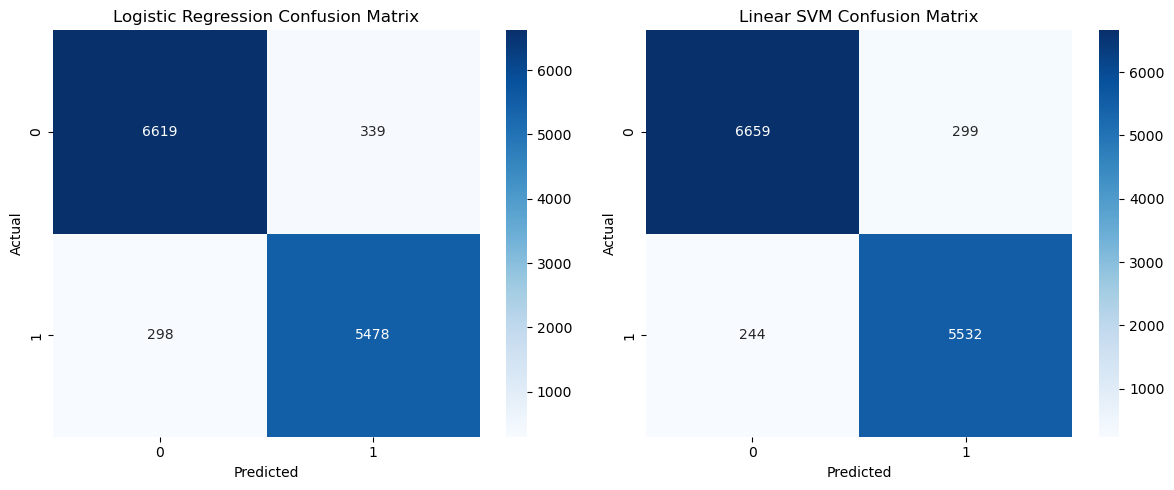

In [6]:
cm_lr  = confusion_matrix(y_test, pred_lr)
cm_svm = confusion_matrix(y_test, pred_svm)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_lr, annot=True, fmt="d", ax=axes[0], cmap="Blues")
axes[0].set_title("Logistic Regression Confusion Matrix")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("Actual")

sns.heatmap(cm_svm, annot=True, fmt="d", ax=axes[1], cmap="Blues")
axes[1].set_title("Linear SVM Confusion Matrix")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

## Collect Misclassified Examples


In [7]:
results = test_df.copy()
results["pred_lr"] = pred_lr
results["pred_svm"] = pred_svm

results["lr_correct"] = (results["label"] == results["pred_lr"])
results["svm_correct"] = (results["label"] == results["pred_svm"])

# Text preview column (so notebook doesn't lag)
results["preview"] = results["combined_text"].str.slice(0, 200)
results.head()

,combined_text,label,pred_lr,pred_svm,lr_correct,svm_correct,preview
0,trump threatens to file battery charges on rep...,1,1,1,True,True,trump threatens to file battery charges on rep...
1,clinton thinks regulators should scrutinize at...,0,0,0,True,True,clinton thinks regulators should scrutinize at...
2,putin vows to 'choke' nato [video] november 20...,1,1,1,True,True,putin vows to 'choke' nato [video] november 20...
3,"italy's 5-star, stung by fake news claims, cal...",0,0,0,True,True,"italy's 5-star, stung by fake news claims, cal..."
4,ping-pong as the fountain of youth - the new y...,0,0,0,True,True,ping-pong as the fountain of youth - the new y...


## Fake predicted as Real

In [8]:
lr_fn = results[(results["label"] == 1) & (results["pred_lr"] == 0)]
svm_fn = results[(results["label"] == 1) & (results["pred_svm"] == 0)]

print("LR false negatives (fake→real):", len(lr_fn))
print("SVM false negatives (fake→real):", len(svm_fn))

lr_fn[["label", "pred_lr", "preview"]].head(10)

LR false negatives (fake→real): 298
SVM false negatives (fake→real): 244


,label,pred_lr,preview
5,1,0,pa. lawmakers approve ban on naming officers i...
176,1,0,japan approves already dead tpp deal ruling co...
193,1,0,just in: obama appointed judge presiding over ...
253,1,0,how president eisenhower solved the illegal im...
287,1,0,sessions calls out lying senator in heated exc...
316,1,0,breaking: republican majority house caves to o...
329,1,0,iran’s carpet exports to us at $50mn iran’s ca...
358,1,0,israel refuses participation in paris peace co...
416,1,0,penguins and baby iguana ‘will not follow plan...
484,1,0,breaking: muslim terrorists strike two popular...


In [9]:
lr_fp = results[(results["label"] == 0) & (results["pred_lr"] == 1)]
svm_fp = results[(results["label"] == 0) & (results["pred_svm"] == 1)]

print("LR false positives (real→fake):", len(lr_fp))
print("SVM false positives (real→fake):", len(svm_fp))

lr_fp[["label", "pred_lr", "preview"]].head(10)


LR false positives (real→fake): 339
SVM false positives (real→fake): 299


,label,pred_lr,preview
68,0,1,‘this only confirms the image of the u.s.a.’ -...
119,0,1,tancredo: over 300 sanctuary cities are costin...
163,0,1,michael moore: ’only hope’ to avoid nuclear wa...
215,0,1,i used an assault rifle in the army. i don’t t...
280,0,1,"welcome to trump county, u.s.a. it is a little..."
281,0,1,california college professor who called trump’...
285,0,1,the week that hillary clinton 2016 speculation...
351,0,1,debating the future of american power abroad t...
386,0,1,israeli minister miri regev: ‘thank god’ obama...
439,0,1,"in trump's world, women have always been objec..."


## Top informative words

In [10]:
feature_names = vectorizer.get_feature_names_out()
coefs = lr.coef_[0]

top_fake_idx = np.argsort(coefs)[-20:][::-1]  # strongest toward label=1
top_real_idx = np.argsort(coefs)[:20]         # strongest toward label=0

top_fake_words = [(feature_names[i], coefs[i]) for i in top_fake_idx]
top_real_words = [(feature_names[i], coefs[i]) for i in top_real_idx]

print("Top words pushing prediction toward FAKE (label=1):")
for w, c in top_fake_words:
    print(f"{w:25s} {c:.4f}")

print("\nTop words pushing prediction toward REAL (label=0):")
for w, c in top_real_words:
    print(f"{w:25s} {c:.4f}")


Top words pushing prediction toward FAKE (label=1):
featured image            10.0713
image                     9.7930
video                     9.6692
featured                  9.4279
hillary                   6.9509
twitter com               6.7034
getty                     6.6795
getty images              6.2945
october                   6.1125
read                      5.5955
2016                      5.4204
breaking                  4.9174
com                       4.9057
just                      4.7333
november                  4.6943
watch                     4.5517
images                    4.3795
anti                      3.8579
today                     3.7956
november 2016             3.5144

Top words pushing prediction toward REAL (label=0):
reuters                   -22.4383
said                      -15.4331
breitbart                 -13.5229
washington reuters        -8.5376
follow                    -8.1586
president donald          -7.8605
twitter                   -

## Plotting

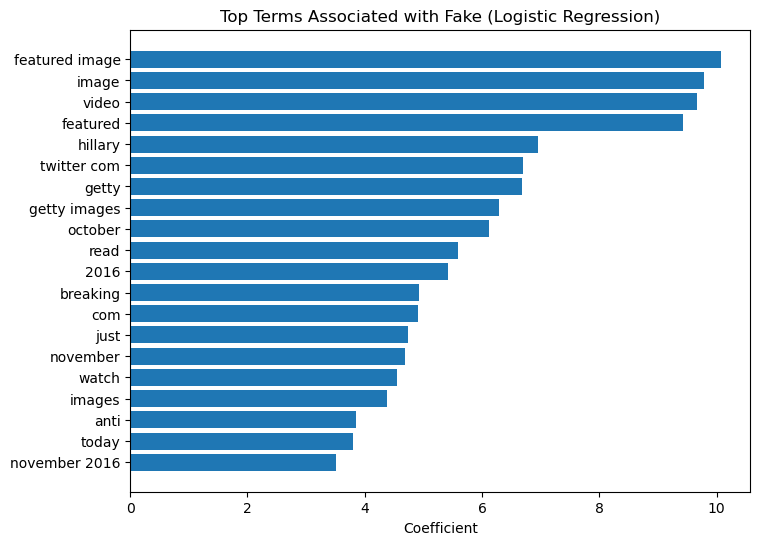

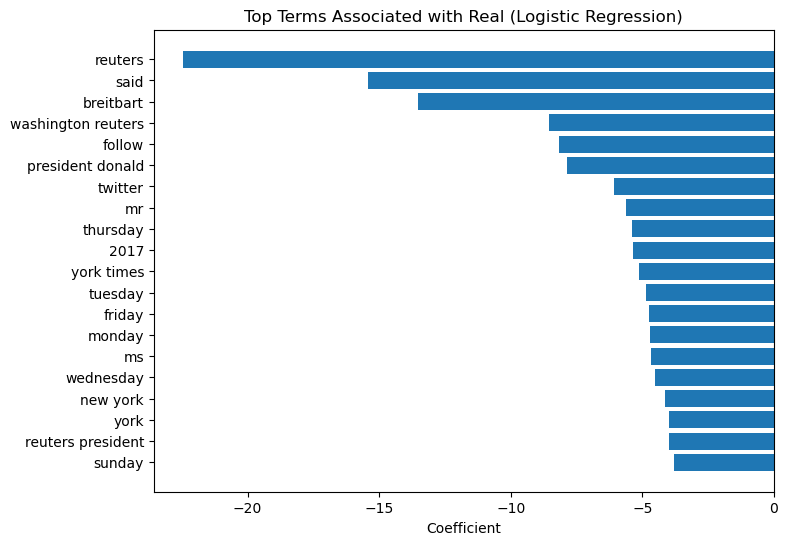

In [11]:
top_fake_df = pd.DataFrame(top_fake_words, columns=["term", "coef"])
top_real_df = pd.DataFrame(top_real_words, columns=["term", "coef"])

plt.figure(figsize=(8,6))
plt.barh(top_fake_df["term"][::-1], top_fake_df["coef"][::-1])
plt.title("Top Terms Associated with Fake (Logistic Regression)")
plt.xlabel("Coefficient")
plt.show()

plt.figure(figsize=(8,6))
plt.barh(top_real_df["term"][::-1], top_real_df["coef"][::-1])
plt.title("Top Terms Associated with Real (Logistic Regression)")
plt.xlabel("Coefficient")
plt.show()


The model heavily relies on stylistic and source-related vocabulary patterrns. Terms associated with professional words such as reuters, weekdays, said make the articles into real news, while media-embedded and sensational terms (breaking, video, featured image) are associated with fake news.